In [ ]:
from IPython.display import display_html
def restartkernel(): display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
try: restartkernel()
except: pass

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [2]:
# from condensate import Condensate, Environment

In [2]:
from condensate.core import gpcore
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
import time
import h5py
import pandas as pd
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
# constants
hbar = 1.05e-34
a0 = 5.3e-11

In [5]:
class Wavefunction():
    def __init__(self, DIM=512, fov=400e-6, N=1e6, omegaz=10, a_s=100*a0, mass=3.8e-26):
        self.DIM = DIM
        self.fov = fov
        self.N = N
        self.omegaz = omegaz
        self.a_s = a_s
        self.mass = mass
        self.g = N* 4 * np.pi * (hbar**2) * (a_s  / mass)
        self.g *= np.sqrt(mass * omegaz / (2*np.pi*hbar))
        self.omega = 2*np.pi
        self.epsilon = 0
        self.lb = np.sqrt(hbar / (2*mass *self.omega))
        
        self.Psi = (1+0.j)*np.zeros((DIM,DIM))
        self.V = np.zeros((DIM,DIM))
        self.initialize_Psi()
        self.reference_frame = {'rotating': False, 'omegaR': [self.omega]}
        self.absorber = {'on': False, 'strength': 1, 'radius': self.fov/2}
        self.spoon = {
            'on': False, 'strength':1e5, 'radius': 20e-6,
            'leapx': -250, 'leapy': -500, 'leapxscale': 1, 'leapyscale': 1, 'zcontrol': False
        }
        
        print(f'''
            Running condensate on {DIM}x{DIM} grid with:
            atom number: {N:.0e} 
            mass:        {mass:.2e}
        ''')
        
        
    @property
    def density(self):
        self._density = np.abs(self.Psi) ** 2
        return self._density
    
    @property
    def phase(self):
        self._phase = np.angle(self.Psi)
        return self._phase
        
    def show_density(self,):
        a = plt.imshow(self.density)
        plt.colorbar()
        plt.show()
        
    def show_phase(self,):
        a = plt.imshow(self.phase)
        plt.colorbar()
        plt.show()
        
        
    def initialize_Psi(self, width=100, vortexnumber=0):
        DIM = self.DIM
        x = (1+0.j)*np.zeros((DIM,DIM))
        for i in range(DIM):
            for j in range(DIM):
                phi =vortexnumber*np.arctan2((i-DIM//2), (j-DIM//2))
                phase = np.exp(1.j * np.mod(phi,2*np.pi))
                self.Psi[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
                self.Psi[i,j] *= phase
        
    def harmonic_potential(self, omega, epsilon):
        self.omega = omega
        self.lb = np.sqrt(hbar / (2*mass *omega))
        self.epsilon = epsilon
            
    def rotating_frame(self, omegaR):
        self.reference_frame = {'rotating': True, 'omegaR': omegaR}
    
    def lab_frame(self):
        self.reference_frame['rotating'] = False
            
    def absorbing_boundaries(self, strength, radius):
        self.absorber = {'on': True, 'strength': strength, 'radius': radius}
    
    def no_absorbing_boundaries(self):
        self.absorber['on'] = False
        
        
    
    def relax(self, **kwargs):
        kwargs['imaginary_time'] = True
        self.evolve(**kwargs)
        
    def evolve(self, dt=1e-4, steps=1000, imaginary_time=False, cooling=0.01,
               showevery=40, show=True, vmax='auto'):
        
        gpcore.Setup(self.DIM, self.fov, self.g, dt, imaginary_time, cooling)
        
        gpcore.SetHarmonicPotential(self.omega, self.epsilon)
        
        if self.absorber['on']:
            gpcore.AbsorbingBoundaryConditions(self.absorber['strength'], self.absorber['radius'])
            
        if self.reference_frame['rotating']:
            omegaR = self.reference_frame['omegaR']
            if (steps!=0) and (len(omegaR)!=steps): 
                raise ValueError('Check the length of omegaR (it should be steps)')
            gpcore.RotatingFrame(omegaR)
            
        if vmax=='auto': vmax=np.max(self.density)
            
        gpcore.Evolve(self.Psi, int(steps), int(showevery), show, vmax)


In [6]:
c = Wavefunction(DIM=512)


            Running condensate on 512x512 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


In [25]:
c.initialize_Psi(width=100, vortexnumber=6)
c.rotating_frame(omegaR=[0.85*c.omega]*5000)

In [28]:
c.relax(vmax=2e7,dt=5e-4, steps=5000)

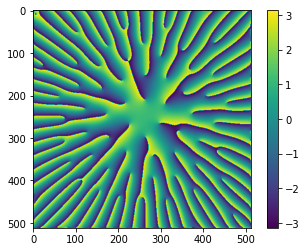

In [29]:
c.show_phase()

In [20]:
c.evolve(dt=1e-4,steps=0, cooling=0)

In [17]:
c.lab_frame()

In [63]:
c.harmonic_potential(c.omega,0.2)